In [1]:
#!pip install bluepyopt

In [2]:
import random, numpy

from deap import creator
import deap.gp
import deap.benchmarks
import bluepyopt.deapext

import neuron
neuron.h.load_file('stdrun.hoc')

import efel

%matplotlib inline
# from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from IPython import display

--No graphics will be displayed.


In [3]:
def evaluate(individual, target_voltage1=-80, target_voltage2=-60):
    """
    Evaluate a neuron model with parameters e_pas and g_pas, extracts
    features from resulting traces and returns a tuple with
    abs(voltage_base-target_voltage1) and 
    abs(steady_state_voltage-target_voltage2)
    """
    
    neuron.h.cvode_active(1)
    neuron.h.v_init = target_voltage1

    soma = neuron.h.Section()

    soma.insert('pas')

    soma.g_pas = individual[0]
    soma.e_pas = individual[1]

    clamp = neuron.h.IClamp(0.5, sec=soma)

    stim_start = 200
    stim_end = 600

    clamp.amp = 1.0
    clamp.delay = stim_start
    clamp.dur = stim_end - stim_start

    voltage = neuron.h.Vector()
    voltage.record(soma(0.5)._ref_v)

    time = neuron.h.Vector()
    time.record(neuron.h._ref_t)

    neuron.h.tstop = stim_end + stim_start
    neuron.h.run()

    trace = {}
    trace['T'] = time
    trace['V'] = voltage
    trace['stim_start'] = [stim_start]
    trace['stim_end'] = [stim_end]
    traces = [trace]

    features = efel.getFeatureValues(traces, ["voltage_base",
                                             "steady_state_voltage_stimend"])
    voltage_base = features[0]["voltage_base"][0]
    steady_state_voltage = features[0]["steady_state_voltage_stimend"][0]
    
    individual.voltage = voltage
    individual.time = time
    individual.target_voltage1 = target_voltage1
    individual.target_voltage2 = target_voltage2
    
    individual.tot_fitness = abs(target_voltage1 - voltage_base) + abs(target_voltage2 - steady_state_voltage)
    
    return abs(target_voltage1 - voltage_base), \
        abs(target_voltage2 - steady_state_voltage)


In [4]:
def plot_selector(population, k, selector=None, **kwargs):  

    pylab.subplot(1, 2, 1)
    pylab.cla()
    for ind in population:
        time = ind.time
        voltage = ind.voltage
        pylab.plot(time, voltage, color='black', alpha=0.2)
        
    import operator
    best_ind = min(population, key=operator.attrgetter("tot_fitness"))
    time = best_ind.time
    voltage = best_ind.voltage
    target_voltage1 = best_ind.target_voltage1
    target_voltage2 = best_ind.target_voltage2
    
    pylab.plot(time, voltage, color='red', linewidth=3)    
    pylab.plot(time, numpy.ones(len(time))*target_voltage1, '--', color='black')
    pylab.plot(time, numpy.ones(len(time))*target_voltage2, '--', color='black')
    pylab.ylim(-90, -40)
    pylab.xlabel('Time (ms)')
    pylab.ylabel('Membrane voltage (mv)')
    
    pylab.subplot(1, 2, 2)
    pylab.cla()
    for ind in population:
        pylab.plot([ind.fitness.values[0]], [ind.fitness.values[1]], 'o', color='grey', alpha=0.2, markersize=15)
    pylab.plot([best_ind.fitness.values[0]], [best_ind.fitness.values[1]], 'o', color='red', markersize=15)
    pylab.xlim([-5, 20])
    pylab.ylim([-5, 20])
    pylab.xlabel("Resting membrane potential error")
    pylab.ylabel("Steady state voltage error")
    
    display.clear_output(wait=True)
    pylab.draw()
    display.display(pylab.gcf())
    pylab.pause(0.5)

    selected_pop = selector(population, k, **kwargs)
    
    return selected_pop


In [5]:
# Set random seed
random.seed(1)

# Set number of individuals in population
POP_SIZE = 100

# Set number of individuals to create in every offspring
OFFSPRING_SIZE = 50

# Total number of generation to run
NGEN = 300

# Total population size of EA
ALPHA = POP_SIZE
# Total parent population size of EA
MU = OFFSPRING_SIZE
# Total offspring size of EA
LAMBDA = OFFSPRING_SIZE

# Crossover, mutation probabilities
CXPB = 0.7
MUTPB = 0.3

# Eta parameter of crossover / mutation parameters
# Basically defines how much they 'spread' solution around
# The higher this value, the more spread
ETA = 10.0

# Seletor to use
SELECTOR = "IBEA"

# Number of parameters
IND_SIZE = 2

# Bounds for the parameters
LOWER = [5e-6, -90.0]
UPPER = [9e-5, -50.0]

# Create a fitness function
# By default DEAP selector will try to optimise fitness values,
# so we add a -1 weight value to minise
creator.create("Fitness", deap.base.Fitness, weights=[-1.0] * 2)

class Individual(list):
    def __init__(self, *args):
        list.__init__(self, *args)
        self.time = None
        self.voltage = None

# Create an individual that consists of a list
creator.create("Individual", Individual, fitness=creator.Fitness)

# Define a function that will uniformly pick an individual
def uniform(lower_list, upper_list, dimensions):
    """Fill array """

    if hasattr(lower_list, '__iter__'):
        return [random.uniform(lower, upper) for lower, upper in
                zip(lower_list, upper_list)]
    else:
        return [random.uniform(lower_list, upper_list)
                for _ in range(dimensions)]

# Create a DEAP toolbox
toolbox = deap.base.Toolbox()

# Register the 'uniform' function
toolbox.register("uniformparams", uniform, LOWER, UPPER, IND_SIZE)

# Register the individual format
# An indiviual is create by 'creator.Individual' and parameters are initially
# picked by 'uniform'
toolbox.register(
    "Individual",
    deap.tools.initIterate,
    creator.Individual,
    toolbox.uniformparams)

# Register the population format. It is a list of individuals
toolbox.register("population", deap.tools.initRepeat, list, toolbox.Individual)

# Register the evaluation function for the individuals
toolbox.register("evaluate", evaluate)

# Register the mate operator
toolbox.register(
    "mate",
    deap.tools.cxSimulatedBinaryBounded,
    eta=ETA,
    low=LOWER,
    up=UPPER)

# Register the mutation operator
toolbox.register("mutate", deap.tools.mutPolynomialBounded, eta=ETA,
                 low=LOWER, up=UPPER, indpb=0.1)

# Register the variate operator
toolbox.register("variate", deap.algorithms.varAnd)

# Register the selector (picks parents from population)
toolbox.register("select", plot_selector, selector=bluepyopt.deapext.tools.selIBEA)

# Generate the population object
pop = toolbox.population(n=MU)

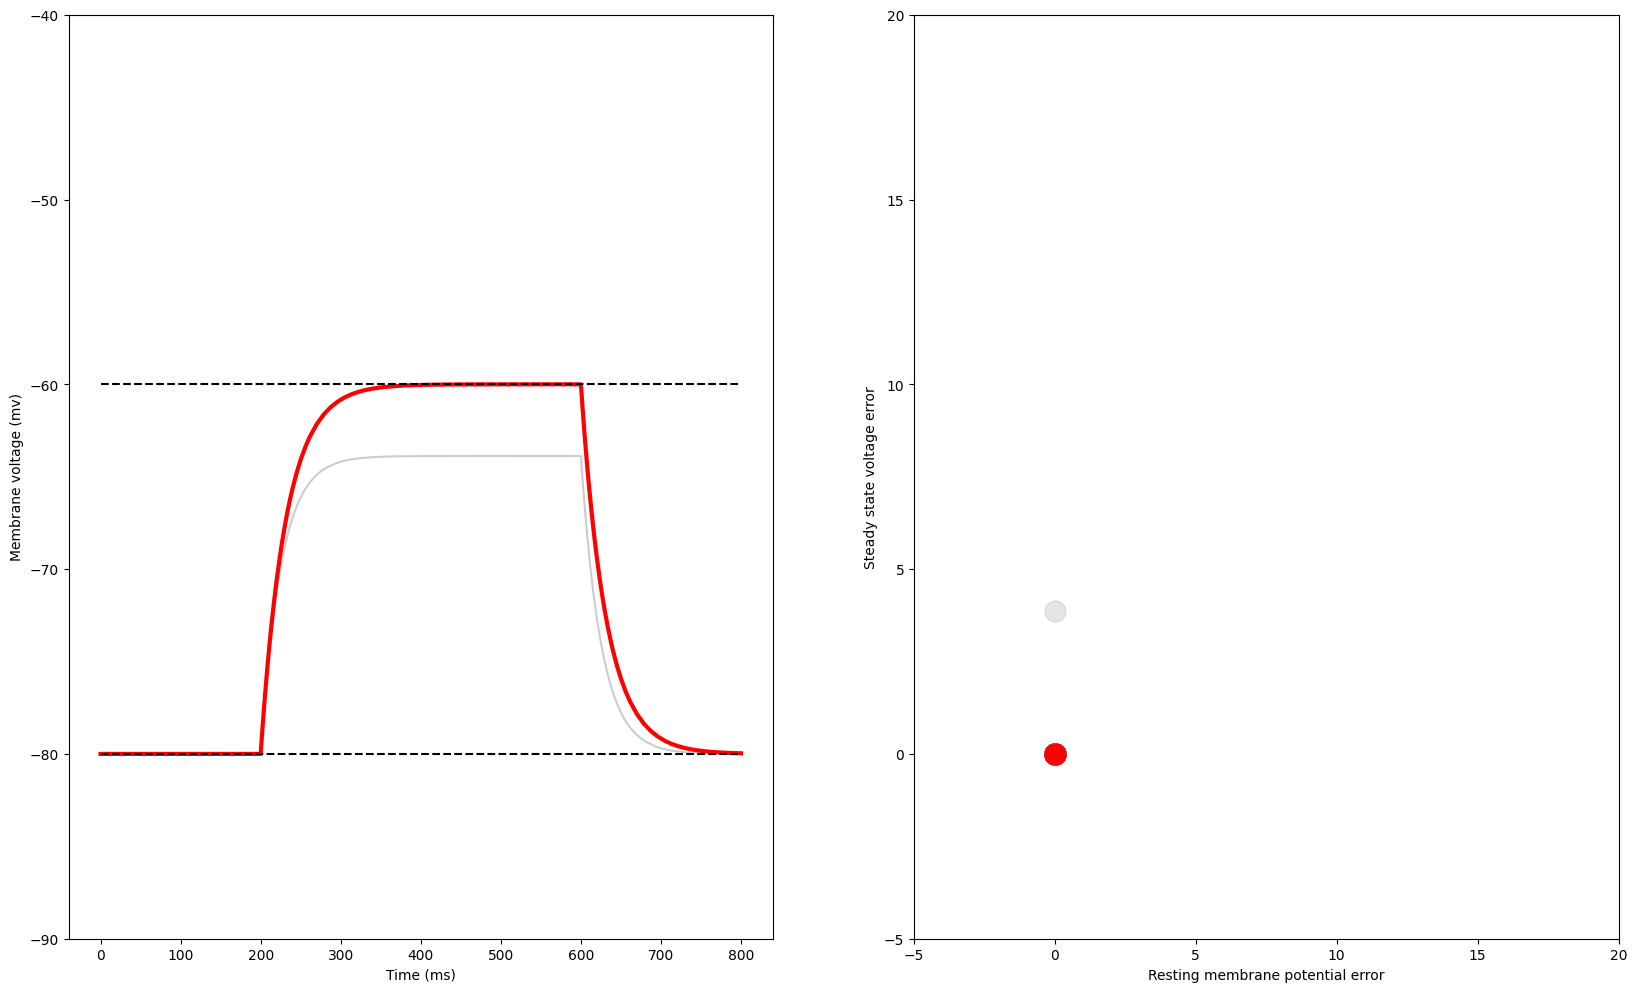

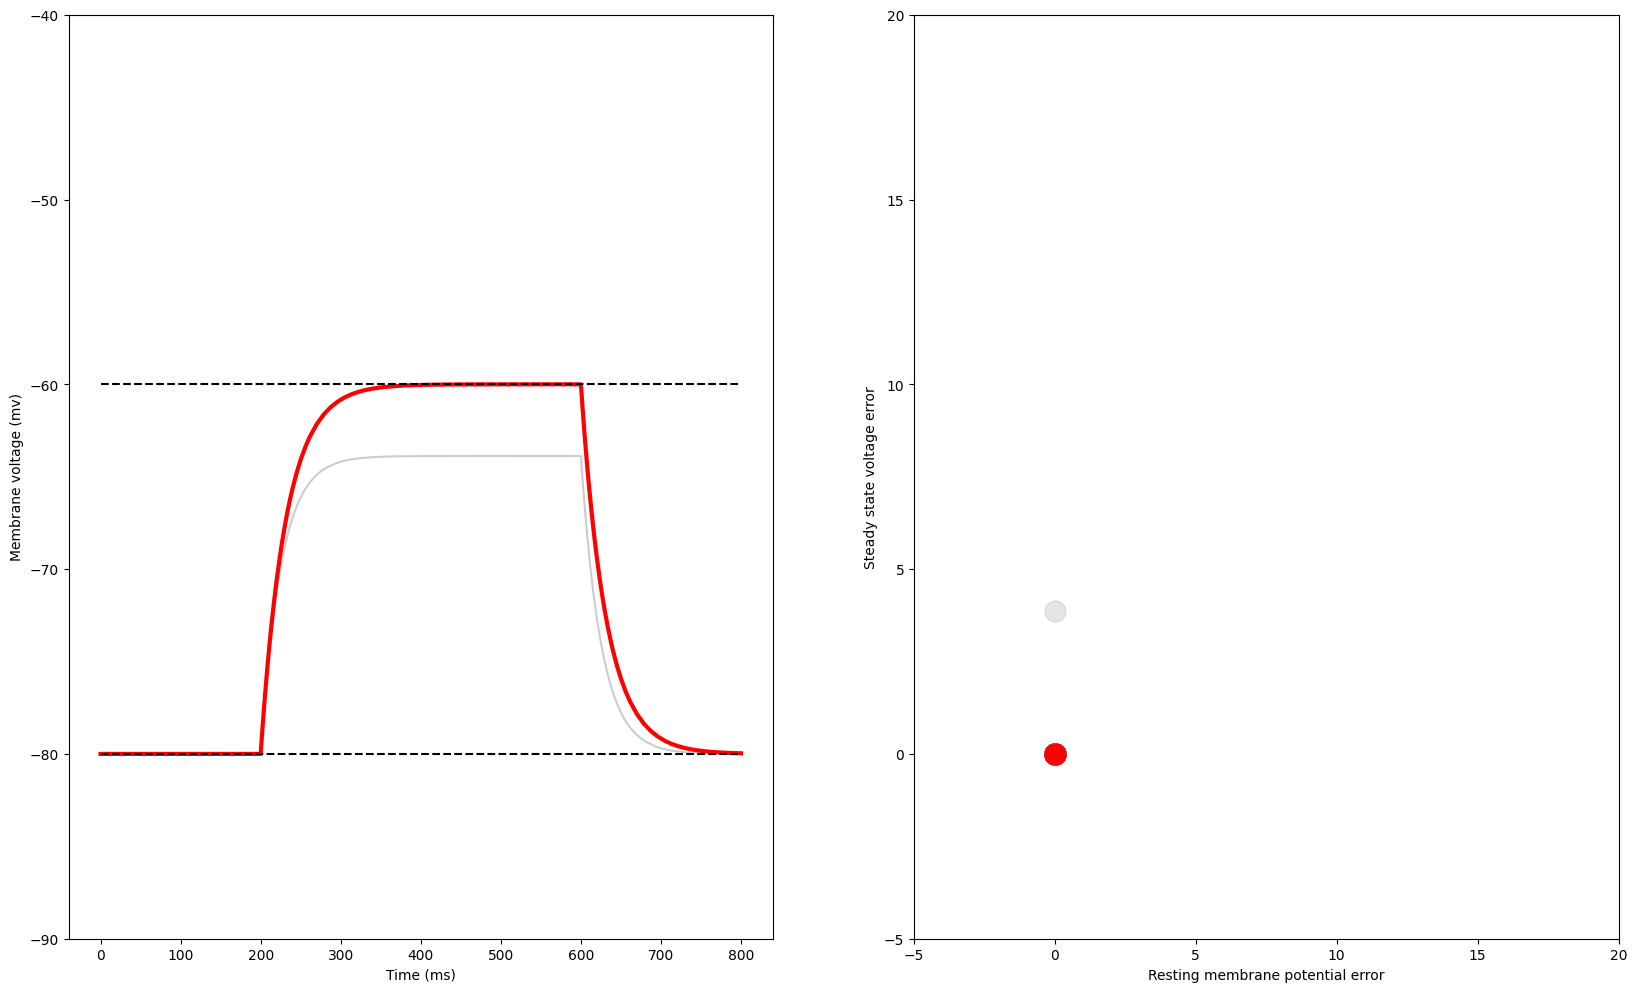

In [6]:
population, hof, logbook, history = bluepyopt.deapext.algorithms.eaAlphaMuPlusLambdaCheckpoint(
    pop,
    toolbox,
    MU,
    CXPB,
    1-CXPB,
    NGEN)